In [1]:
import pywt
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from itertools import chain

import numpy as np
%matplotlib inline

# All the helper functions 

In [2]:
def rescale_image(old_image):
    OldRange = (np.max(old_image) - np.min(old_image))  
    NewRange = (255 - 0)  
    NewValue = (((old_image - np.min(old_image) ) * NewRange) / OldRange) 
    return NewValue

In [281]:
def clamp(image):
    data = np.copy(image)
    mask1 = data > 255
    data[mask1] = 255
    mask2 = data < 0 
    data[mask2] = 0
    
    return data

In [59]:
def visualize_coeffs(coeffs):
    levels = len(coeffs) - 1
    fig, axs = plt.subplots(levels, 3 ,figsize = (levels * 3, 9))
    axs = axs.ravel()
    
    for i,j in zip(range(0,levels*3,3) , range(1,levels+1)):
        axs[i].imshow(coeffs[j][0], 'gray')
        axs[i].set_title('Horizontal Coefficients \n level ' + str(j))
        axs[i+1].imshow(coeffs[j][1], 'gray')
        axs[i+1].set_title('Vertical Coefficients \n level ' + str(j))
        axs[i+2].imshow(coeffs[j][2], 'gray')
        axs[i+2].set_title('Diagonal Coefficients \n level ' + str(j))
        
    fig.tight_layout()

    


In [299]:
def visualize_coeffs_tiled(coeffs, figsize):
    levels = len(coeffs) - 1
    
    image_size = 0
    for i in range(len(coeffs)): 
        image_size = coeffs[i][0].shape[0] + image_size
    
    temp = rescale_image(coeffs[0])    
    for i in range(1, levels+1):
        temp1 = np.hstack((temp, rescale_image(coeffs[i][0])))
        temp2 = np.hstack((rescale_image(coeffs[i][1]), rescale_image(coeffs[i][2])))
        temp = np.vstack((temp1, temp2))
    plt.figure(figsize= figsize)
    
    plt.imshow(temp, 'gray')
    plt.xlim(0,image_size)
    plt.ylim(image_size,0)  
    
    # Add lines
    for i in range(levels): 
        plt.plot([image_size/(2)**(i+1), image_size/2**(i+1)], [0, image_size/ 2**(i)], color='y', linestyle='-', linewidth=1)
        plt.plot([0, image_size/ 2**(i)],[image_size/(2)**(i+1), image_size/2**(i+1)], color='y', linestyle='-', linewidth=1)



In [305]:
def threshold(coeffs, thresholds, mode): 
    '''mode: soft vs. hard'''
    coeffs_new = [coeffs[0]]
    
    for i in range(len(thresholds)):
        cH_new =  pywt.threshold(coeffs[i+1][0], thresholds[i], mode)
        cV_new =  pywt.threshold(coeffs[i+1][1], thresholds[i], mode)
        cD_new =  pywt.threshold(coeffs[i+1][2], thresholds[i], mode)
        coeffs_new.append((cH_new, cV_new, cD_new))


    return coeffs_new

In [486]:
def block_threshold_fixed_scale(coeffs, threshold, neighbor_size):
    '''coeffs: only one scale coeffs, 
    threshold: a scalar
    neiber_size: a scalar giving the length of the square neighbor'''
    neighbor_num = coeffs.shape[0]/neighbor_size
    if neighbor_num != int(neighbor_num):
        raise ValueError('neighbor size must be consistent with the coeffs dimensions')
    
    # Create the neighbors
    splitted_x_axis = np.split(coeffs, neighbor_num, 0) # split along the x axis
    splitter_y_axis = lambda x: np.split(x, neighbor_num, 1)
    neighbors = np.array(list(map(splitter_y_axis , splitted_x_axis)))

    # find norms in neighbors
    norms = np.array([list(map(np.linalg.norm, neigh)) for neigh in neighbors])
    mask = (norms < threshold)
    neighbors[mask] = 0
    
    thresholded_coeffs = neighbors.swapaxes(1, 2).reshape(coeffs.shape)
    
    return thresholded_coeffs



In [493]:
def block_threshold(coeffs, thresholds, neighbor_sizes): 
    '''coeffs: all coeffs from decomposition
    threshold: all thresholds'''
    coeffs_new = [coeffs[0]]
    
    for i in range(len(thresholds)):
        cH_new =  block_threshold_fixed_scale(coeffs[i+1][0], thresholds[i], neighbor_sizes[i])
        cV_new =  block_threshold_fixed_scale(coeffs[i+1][1], thresholds[i], neighbor_sizes[i])
        cD_new =  block_threshold_fixed_scale(coeffs[i+1][2], thresholds[i], neighbor_sizes[i])
        coeffs_new.append((cH_new, cV_new, cD_new))


    return coeffs_new
    
    
    
    

# Load image 

(512, 512)

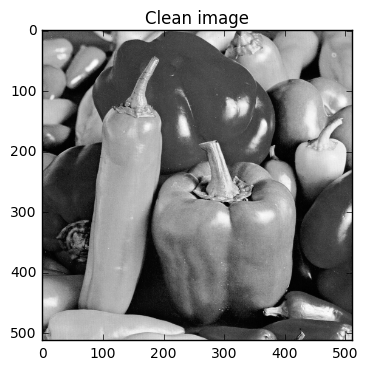

In [6]:
data = mpimg.imread('peppers-bw.bmp')
data = data.astype('float32')
imgplot = plt.imshow(data, 'gray')
plt.title('Clean image')
data.shape

# Decomposition of the clean image at one level

In [286]:
coeffs = pywt.dwt2(data, 'haar' )


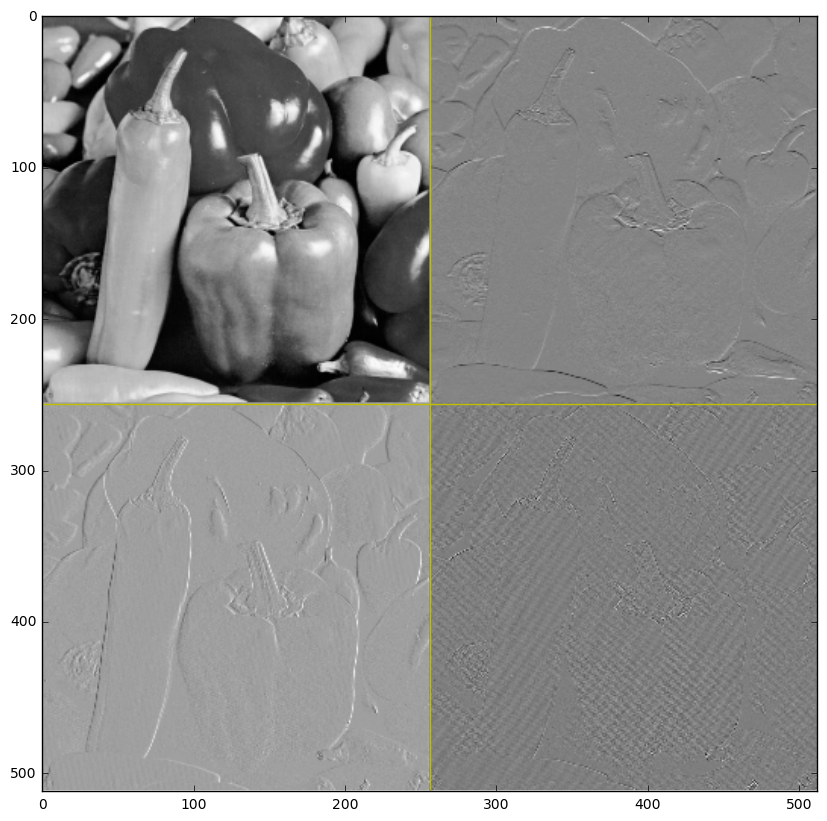

In [300]:
visualize_coeffs_tiled(coeffs,(10,10))

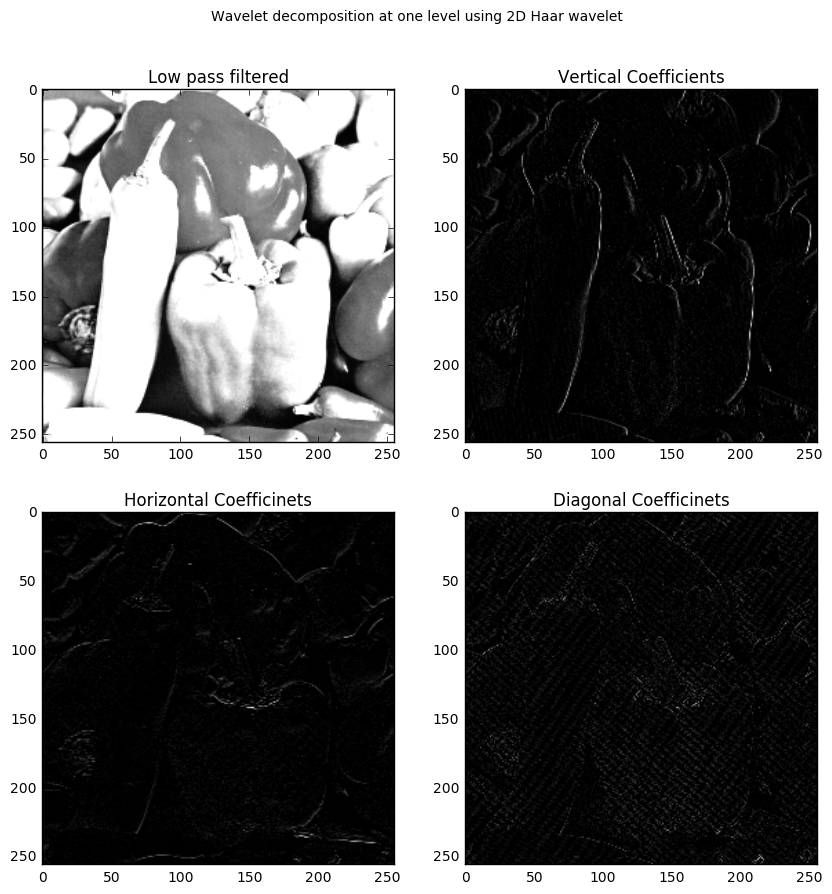

In [287]:
# This is an example of Clamoing the coeffs instead of rescaling them. 
cA, (cH, cV, cD) = coeffs

plt.figure(figsize = (10,10))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10,10))
f.suptitle('Wavelet decomposition at one level using 2D Haar wavelet')

ax1.imshow(clamp(cA), 'gray')
ax1.set_title('Low pass filtered')

ax2.imshow(clamp(cV), 'gray')
ax2.set_title('Vertical Coefficients')

ax3.imshow(clamp(cH), 'gray')
ax3.set_title('Horizontal Coefficinets')

ax4.imshow(clamp(cD), 'gray')
ax4.set_title('Diagonal Coefficinets')



# multi level decomposition of the clean image

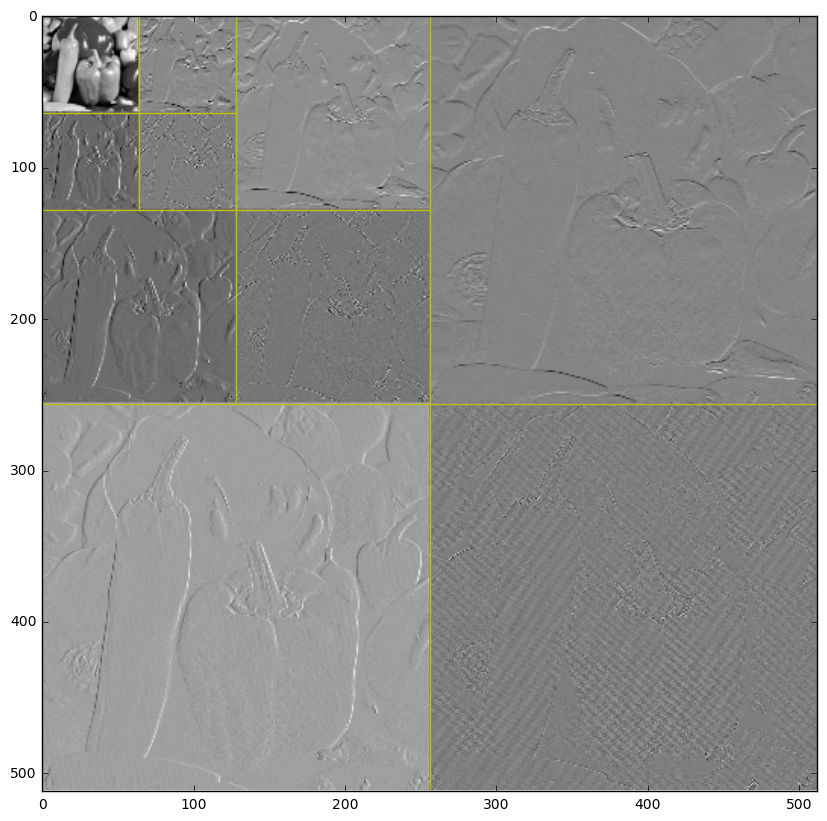

In [301]:
visualize_coeffs_tiled(coeffs_multi, (10,10))


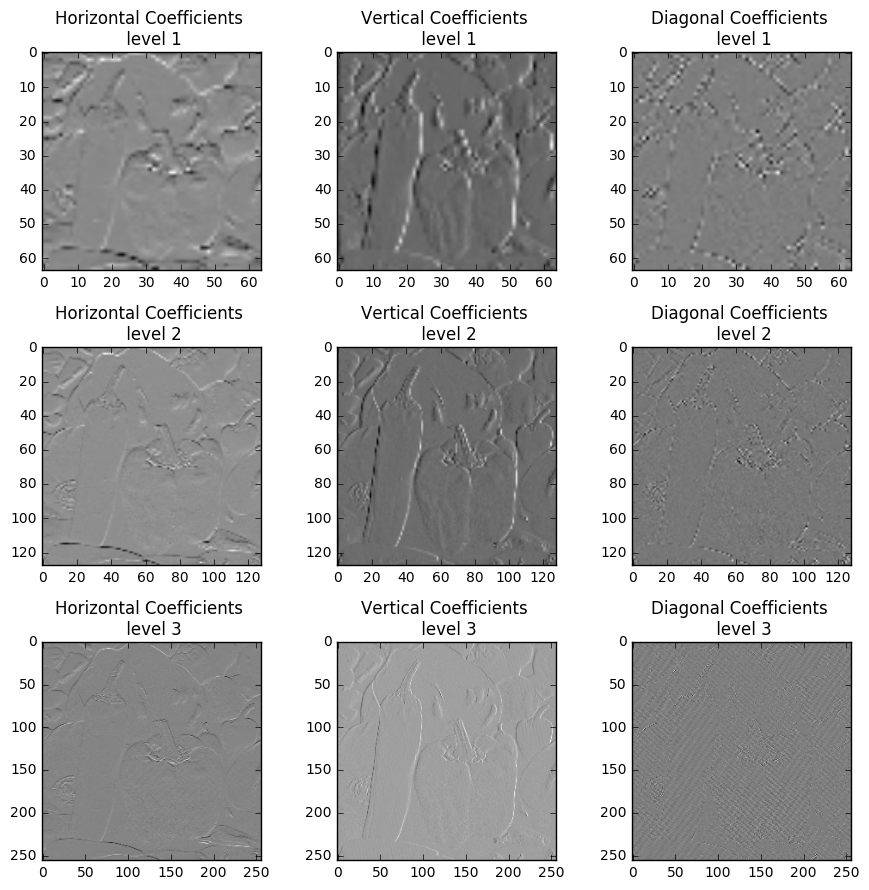

In [79]:
# Same coeffs in row format

coeffs_multi = pywt.wavedec2(data, 'haar', level=3)
cA, (cH3, cV3, cD3), (cH2, cV2, cD2) , (cH1, cV1, cD1)= coeffs_multi
visualize_coeffs(coeffs_multi)


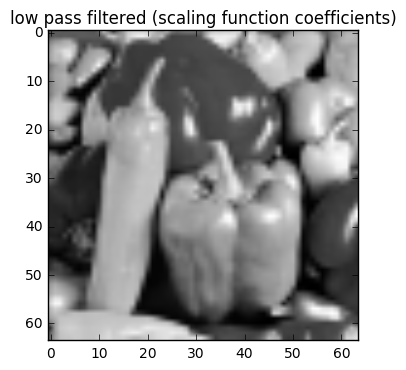

In [80]:
plt.imshow((cA), 'gray')
plt.title('low pass filtered (scaling function coefficients)')

# Multi level Decomposition of the Gaussian Noise 

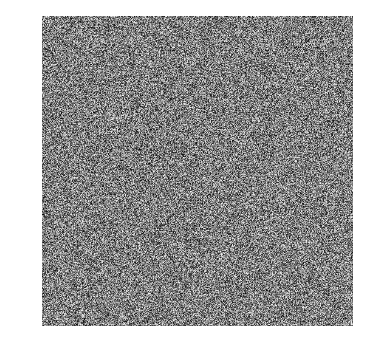

In [96]:
noise = rescale_image(np.random.rand(512,512)) *.5
plt.figure(figsize=(4,4))
imgplot = plt.imshow(noise, 'gray')
# plt.title('noise')
plt.axis('off')

plt.savefig('noise',  pad_inches=0)

In [82]:
coeffs_multi_noise = pywt.wavedec2(noise, 'haar', level=3)
cA_n, (cH3_n, cV3_n, cD3_n), (cH2_n, cV2_n, cD2_n) , (cH1_n, cV1_n, cD1_n)= coeffs_multi_noise

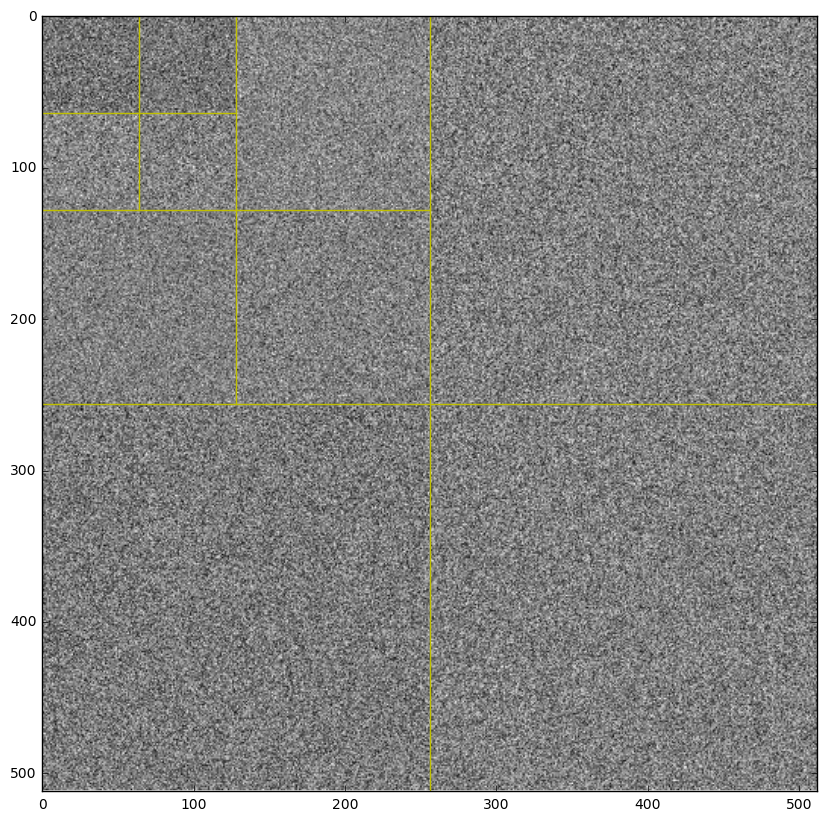

In [302]:
visualize_coeffs_tiled(coeffs_multi_noise, (10,10))

# Multi level Decomposition of the Noisy image

(512, 512)

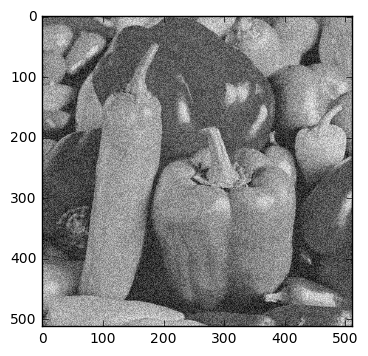

In [85]:
data_noisy = rescale_image(data + noise) 
imgplot = plt.imshow(data_noisy, 'gray')

data.shape

In [ ]:
# multi level decomposition

coeffs_multi_noisy = pywt.wavedec2(data_noisy, 'haar', level=3)

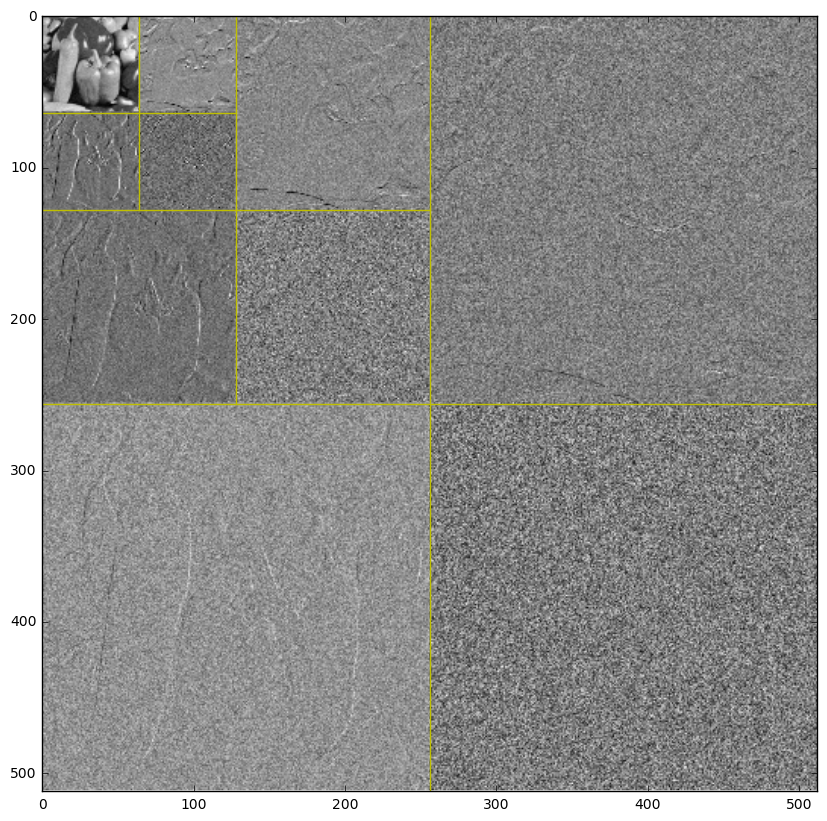

In [303]:
visualize_coeffs_tiled(coeffs_multi_noisy, (10,10))


# Thresholding

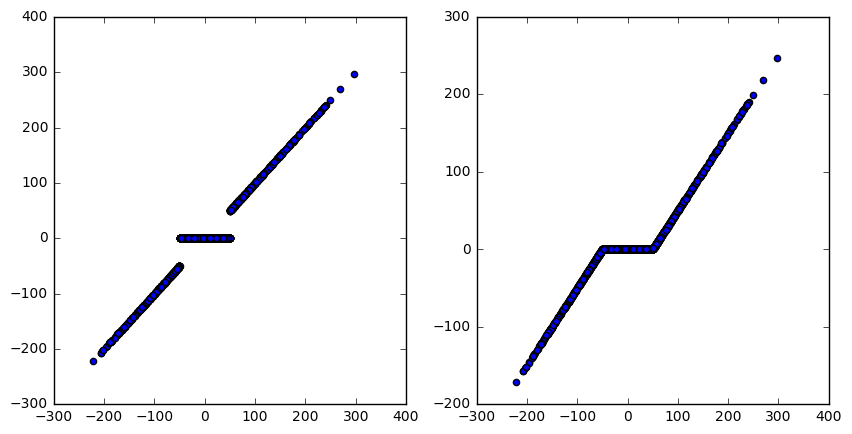

In [88]:
# Check soft thresholding and hard thresholding of the package
f, ((ax1, ax2)) = plt.subplots(1,2 , figsize = (10,5))

ax1.scatter(cV2, pywt.threshold(cV2, 50, 'hard'))
ax2.scatter(cV2, pywt.threshold(cV2, 50, 'soft'))


In [588]:
thresholded_coeffs = threshold(coeffs_multi_noisy, [10,50,80], 'hard')


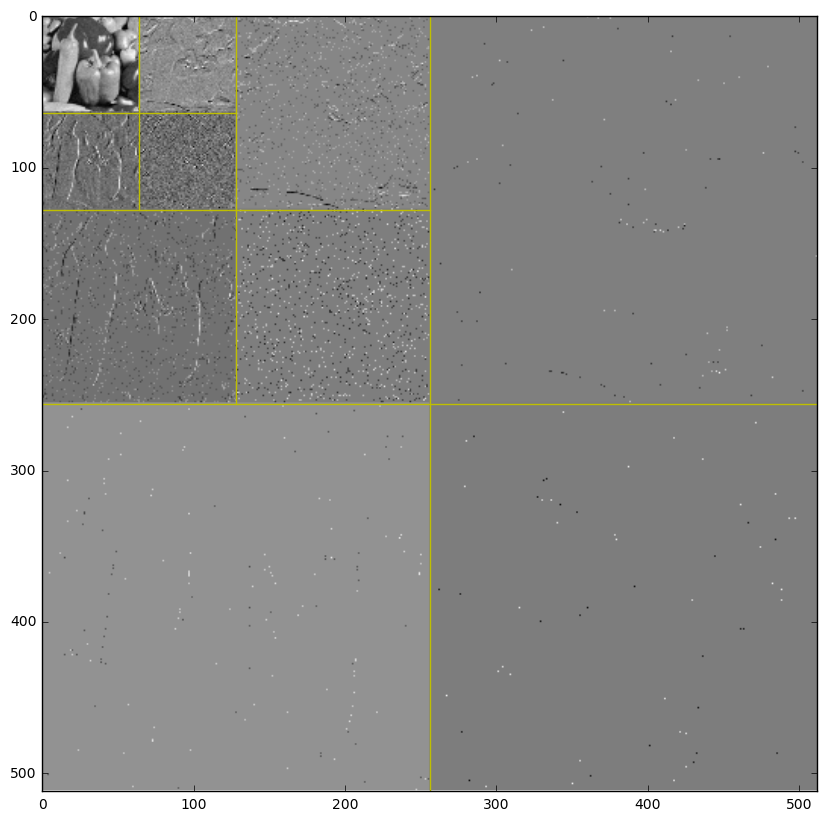

In [589]:
thresholded_coeffs_tile = visualize_coeffs_tiled(thresholded_coeffs , (10,10))

# Reconstruct image from the thresholded coeffs

In [590]:
recon_image = pywt.waverec2(thresholded_coeffs,'haar')


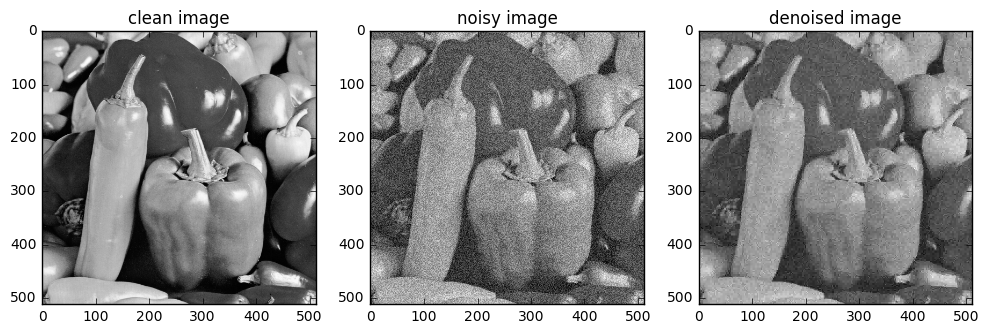

In [591]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))

ax1.imshow(data, 'gray')
ax1.set_title('clean image')
ax2.imshow(data_noisy, 'gray')
ax2.set_title('noisy image')

ax3.imshow(rescale_image(recon_image), 'gray')
ax3.set_title('denoised image')


# Block thresholding

In [615]:
block_thresholded_coeffs = block_threshold(coeffs_multi_noisy, [20,130,250], [2,4,8])

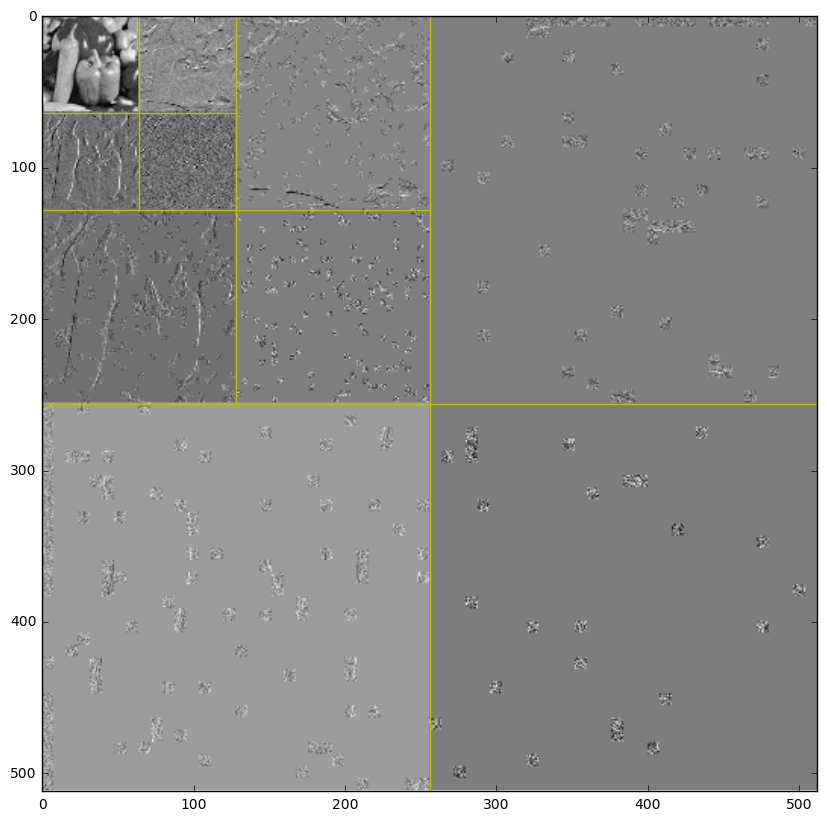

In [616]:
visualize_coeffs_tiled(block_thresholded_coeffs, (10,10))

In [617]:
recon_image_block = pywt.waverec2(block_thresholded_coeffs,'haar')


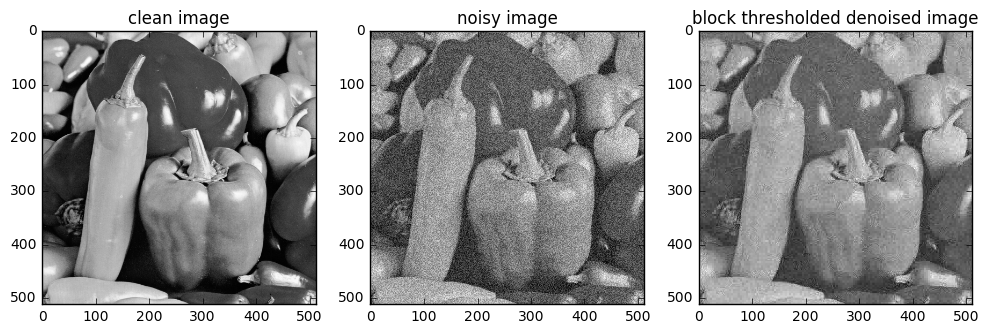

In [618]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))

ax1.imshow(data, 'gray')
ax1.set_title('clean image')
ax2.imshow(data_noisy, 'gray')
ax2.set_title('noisy image')

ax3.imshow(rescale_image(recon_image_block), 'gray')
ax3.set_title('block thresholded denoised image')


# Compare Block thresholding and thresholding

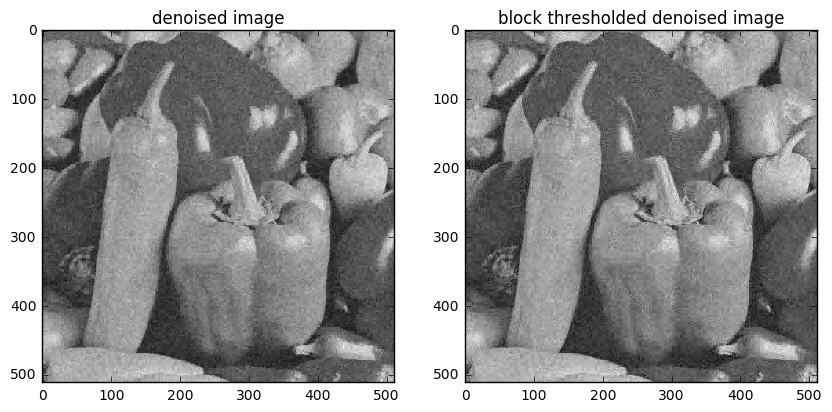

In [619]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.imshow(clamp(recon_image), 'gray')
ax1.set_title('denoised image')


ax2.imshow(clamp(recon_image_block), 'gray')
ax2.set_title('block thresholded denoised image')